In [95]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from datasets import load_dataset
from tqdm.auto import tqdm
import numpy as np 

In [96]:
print(torch.__version__)
print(torch.cuda.get_device_name())

2.7.0+cu128
NVIDIA GeForce RTX 4070 Ti


In [97]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Food101CNN(nn.Module):
    def __init__(self, num_classes=101):
        super(Food101CNN, self).__init__()
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1_1 = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn1_2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2_1 = nn.BatchNorm2d(128)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3_1 = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn3_2 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4_1 = nn.BatchNorm2d(512)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn4_2 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        

        self.fc1 = nn.Linear(512, 1024)
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1_1(self.conv1_1(x)))
        x = F.relu(self.bn1_2(self.conv1_2(x)))
        x = self.pool1(x)

        x = F.relu(self.bn2_1(self.conv2_1(x)))
        x = F.relu(self.bn2_2(self.conv2_2(x)))
        x = self.pool2(x)

        x = F.relu(self.bn3_1(self.conv3_1(x)))
        x = F.relu(self.bn3_2(self.conv3_2(x)))
        x = self.pool3(x)

        x = F.relu(self.bn4_1(self.conv4_1(x)))
        x = F.relu(self.bn4_2(self.conv4_2(x)))
        x = self.pool4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        
        return x

In [98]:
dataset_raw = load_dataset("food101", split="train[:50000]")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image_size = 128

train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def apply_train_transforms(examples):
    examples['pixel_values'] = [train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def apply_val_transforms(examples):
    examples['pixel_values'] = [val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

split_ds_raw = dataset_raw.train_test_split(test_size=0.2, seed=42)
train_ds_raw = split_ds_raw['train']
val_ds_raw = split_ds_raw['test']

train_dataset = train_ds_raw.map(apply_train_transforms, batched=True, remove_columns=['image'])
val_dataset = val_ds_raw.map(apply_val_transforms, batched=True, remove_columns=['image'])

train_dataset.set_format(type='torch', columns=['pixel_values', 'label'])
val_dataset.set_format(type='torch', columns=['pixel_values', 'label'])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

Map:  70%|███████   | 7000/10000 [00:17<00:07, 392.50 examples/s]q:\my_proj\.venv\Lib\site-packages\PIL\TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Map: 100%|██████████| 10000/10000 [00:25<00:00, 388.79 examples/s]


In [99]:
NUM_CLASSES = 101
model = Food101CNN(num_classes=NUM_CLASSES).to(device)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [100]:
num_epochs = 30
best_val_accuracy = 0.0
patience_counter = 0
early_stopping_patience = 5

print(f"Початок навчання {num_epochs} епохах...")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    train_progress_bar = tqdm(train_loader, desc=f"Епоха {epoch+1}/{num_epochs} [Навчання]", leave=False)
    for batch in train_progress_bar:
        inputs = batch['pixel_values'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
        train_progress_bar.set_postfix(loss=loss.item())

    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_accuracy = 100 * correct_train / total_train
    
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    val_progress_bar = tqdm(val_loader, desc=f"Епоха {epoch+1}/{num_epochs} [Валідація]", leave=False)
    with torch.no_grad():
        for batch in val_progress_bar:
            inputs = batch['pixel_values'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            val_progress_bar.set_postfix(loss=loss.item())
            
    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_val_accuracy = 100 * correct_val / total_val
    
    print(f"Епоха {epoch+1}/{num_epochs}:")
    print(f"  Навчання: Втрати = {epoch_train_loss:.4f}, Точність = {epoch_train_accuracy:.2f}%")
    print(f"  Валідація: Втрати = {epoch_val_loss:.4f}, Точність = {epoch_val_accuracy:.2f}%")
    
    scheduler.step()
    print(f"  Теперішня швидкість навчання: {optimizer.param_groups[0]['lr']:.6f}")

    if epoch_val_accuracy > best_val_accuracy:
        print(f"  Точність на валідації покращилась з {best_val_accuracy:.2f}% до {epoch_val_accuracy:.2f}%. Зберігаємо модель...")
        best_val_accuracy = epoch_val_accuracy
        torch.save(model.state_dict(), 'food101_cnn_best_model.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"  Точність на валідації не покращилась. Рахунок терпіння: {patience_counter}/{early_stopping_patience}")

    if patience_counter >= 5:
        print(f"  Рання зупинка! Модель не покращувалась протягом {early_stopping_patience} епох.")
        break

print("Навчання завершено.")
print(f"Найкраща точність на валідації: {best_val_accuracy:.2f}%")

Початок навчання 30 епохах...


Епоха 1/30:
  Навчання: Втрати = 4.0484, Точність = 4.71%
  Валідація: Втрати = 3.8938, Точність = 7.12%
  Теперішня швидкість навчання: 0.001000
  Точність на валідації покращилась з 0.00% до 7.12%. Зберігаємо модель...


Епоха 2/30:
  Навчання: Втрати = 3.7877, Точність = 8.20%
  Валідація: Втрати = 3.6406, Точність = 10.77%
  Теперішня швидкість навчання: 0.001000
  Точність на валідації покращилась з 7.12% до 10.77%. Зберігаємо модель...


Епоха 3/30:
  Навчання: Втрати = 3.5667, Точність = 11.49%
  Валідація: Втрати = 3.6514, Точність = 11.82%
  Теперішня швидкість навчання: 0.001000
  Точність на валідації покращилась з 10.77% до 11.82%. Зберігаємо модель...


Епоха 4/30:
  Навчання: Втрати = 3.3632, Точність = 15.12%
  Валідація: Втрати = 3.6272, Точність = 12.93%
  Теперішня швидкість навчання: 0.001000
  Точність на валідації покращилась з 11.82% до 12.93%. Зберігаємо модель...


Епоха 5/30:
  Навчання: Втрати = 3.2013, Точність = 18.20%
  Валідація: Втрати = 3.1873, Точність = 19.15%
  Теперішня швидкість навчання: 0.001000
  Точність на валідації покращилась з 12.93% до 19.15%. Зберігаємо модель...


Епоха 6/30:
  Навчання: Втрати = 3.0592, Точність = 21.24%
  Валідація: Втрати = 3.0802, Точність = 21.48%
  Теперішня швидкість навчання: 0.001000
  Точність на валідації покращилась з 19.15% до 21.48%. Зберігаємо модель...


Епоха 7/30:
  Навчання: Втрати = 2.9175, Точність = 24.39%
  Валідація: Втрати = 2.9394, Точність = 24.83%
  Теперішня швидкість навчання: 0.000100
  Точність на валідації покращилась з 21.48% до 24.83%. Зберігаємо модель...


Епоха 8/30:
  Навчання: Втрати = 2.6569, Точність = 30.16%
  Валідація: Втрати = 2.5188, Точність = 34.49%
  Теперішня швидкість навчання: 0.000100
  Точність на валідації покращилась з 24.83% до 34.49%. Зберігаємо модель...


Епоха 9/30:
  Навчання: Втрати = 2.5835, Точність = 31.65%
  Валідація: Втрати = 2.4559, Точність = 36.29%
  Теперішня швидкість навчання: 0.000100
  Точність на валідації покращилась з 34.49% до 36.29%. Зберігаємо модель...


Епоха 10/30:
  Навчання: Втрати = 2.5461, Точність = 32.69%
  Валідація: Втрати = 2.4482, Точність = 36.18%
  Теперішня швидкість навчання: 0.000100
  Точність на валідації не покращилась. Рахунок терпіння: 1/5


Епоха 11/30:
  Навчання: Втрати = 2.5112, Точність = 33.53%
  Валідація: Втрати = 2.4180, Точність = 37.21%
  Теперішня швидкість навчання: 0.000100
  Точність на валідації покращилась з 36.29% до 37.21%. Зберігаємо модель...


Епоха 12/30:
  Навчання: Втрати = 2.4760, Точність = 34.37%
  Валідація: Втрати = 2.3783, Точність = 38.02%
  Теперішня швидкість навчання: 0.000100
  Точність на валідації покращилась з 37.21% до 38.02%. Зберігаємо модель...


Епоха 13/30:
  Навчання: Втрати = 2.4450, Точність = 35.13%
  Валідація: Втрати = 2.3654, Точність = 38.34%
  Теперішня швидкість навчання: 0.000100
  Точність на валідації покращилась з 38.02% до 38.34%. Зберігаємо модель...


Епоха 14/30:
  Навчання: Втрати = 2.4138, Точність = 35.71%
  Валідація: Втрати = 2.3248, Точність = 39.28%
  Теперішня швидкість навчання: 0.000010
  Точність на валідації покращилась з 38.34% до 39.28%. Зберігаємо модель...


Епоха 15/30:
  Навчання: Втрати = 2.3685, Точність = 36.52%
  Валідація: Втрати = 2.3186, Точність = 39.30%
  Теперішня швидкість навчання: 0.000010
  Точність на валідації покращилась з 39.28% до 39.30%. Зберігаємо модель...


Епоха 16/30:
  Навчання: Втрати = 2.3564, Точність = 37.03%
  Валідація: Втрати = 2.3149, Точність = 39.48%
  Теперішня швидкість навчання: 0.000010
  Точність на валідації покращилась з 39.30% до 39.48%. Зберігаємо модель...


Епоха 17/30:
  Навчання: Втрати = 2.3579, Точність = 37.22%
  Валідація: Втрати = 2.3104, Точність = 39.71%
  Теперішня швидкість навчання: 0.000010
  Точність на валідації покращилась з 39.48% до 39.71%. Зберігаємо модель...


Епоха 18/30:
  Навчання: Втрати = 2.3532, Точність = 37.22%
  Валідація: Втрати = 2.3028, Точність = 39.71%
  Теперішня швидкість навчання: 0.000010
  Точність на валідації не покращилась. Рахунок терпіння: 1/5


Епоха 19/30:
  Навчання: Втрати = 2.3474, Точність = 37.56%
  Валідація: Втрати = 2.3050, Точність = 39.64%
  Теперішня швидкість навчання: 0.000010
  Точність на валідації не покращилась. Рахунок терпіння: 2/5


Епоха 20/30:
  Навчання: Втрати = 2.3504, Точність = 37.26%
  Валідація: Втрати = 2.3194, Точність = 39.69%
  Теперішня швидкість навчання: 0.000010
  Точність на валідації не покращилась. Рахунок терпіння: 3/5


Епоха 21/30:
  Навчання: Втрати = 2.3431, Точність = 37.55%
  Валідація: Втрати = 2.2980, Точність = 39.81%
  Теперішня швидкість навчання: 0.000001
  Точність на валідації покращилась з 39.71% до 39.81%. Зберігаємо модель...


Епоха 22/30:
  Навчання: Втрати = 2.3446, Точність = 37.29%
  Валідація: Втрати = 2.2961, Точність = 39.94%
  Теперішня швидкість навчання: 0.000001
  Точність на валідації покращилась з 39.81% до 39.94%. Зберігаємо модель...


Епоха 23/30:
  Навчання: Втрати = 2.3410, Точність = 37.42%
  Валідація: Втрати = 2.3045, Точність = 39.91%
  Теперішня швидкість навчання: 0.000001
  Точність на валідації не покращилась. Рахунок терпіння: 1/5


Епоха 24/30:
  Навчання: Втрати = 2.3406, Точність = 37.67%
  Валідація: Втрати = 2.2985, Точність = 39.87%
  Теперішня швидкість навчання: 0.000001
  Точність на валідації не покращилась. Рахунок терпіння: 2/5


Епоха 25/30:
  Навчання: Втрати = 2.3368, Точність = 37.41%
  Валідація: Втрати = 2.2977, Точність = 39.81%
  Теперішня швидкість навчання: 0.000001
  Точність на валідації не покращилась. Рахунок терпіння: 3/5


Епоха 26/30:
  Навчання: Втрати = 2.3424, Точність = 37.47%
  Валідація: Втрати = 2.2987, Точність = 39.80%
  Теперішня швидкість навчання: 0.000001
  Точність на валідації не покращилась. Рахунок терпіння: 4/5


Епоха 27/30:
  Навчання: Втрати = 2.3369, Точність = 37.30%
  Валідація: Втрати = 2.2995, Точність = 39.88%
  Теперішня швидкість навчання: 0.000001
  Точність на валідації не покращилась. Рахунок терпіння: 5/5


Епоха 28/30:
  Навчання: Втрати = 2.3346, Точність = 37.66%
  Валідація: Втрати = 2.2990, Точність = 39.70%
  Теперішня швидкість навчання: 0.000000
  Точність на валідації не покращилась. Рахунок терпіння: 6/5


Епоха 29/30:
  Навчання: Втрати = 2.3361, Точність = 37.84%
  Валідація: Втрати = 2.2973, Точність = 39.88%
  Теперішня швидкість навчання: 0.000000
  Точність на валідації не покращилась. Рахунок терпіння: 7/5


Епоха 30/30:
  Навчання: Втрати = 2.3390, Точність = 37.78%
  Валідація: Втрати = 2.2971, Точність = 39.89%
  Теперішня швидкість навчання: 0.000000
  Точність на валідації не покращилась. Рахунок терпіння: 8/5
Навчання завершено.
Найкраща точність на валідації: 39.94%


Для 50_000 даних:

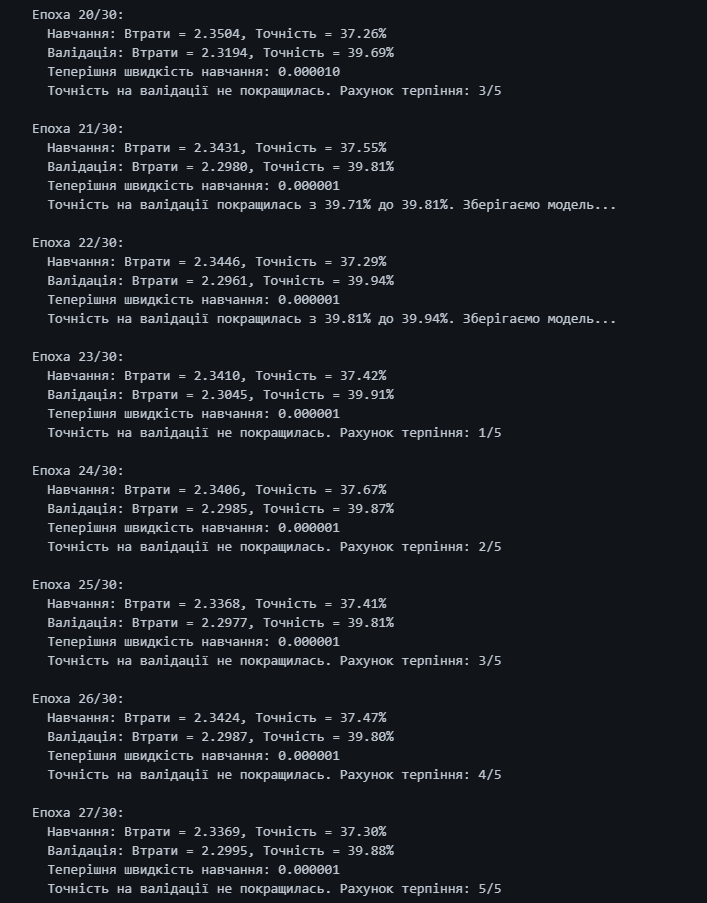

Для 10000 даних:

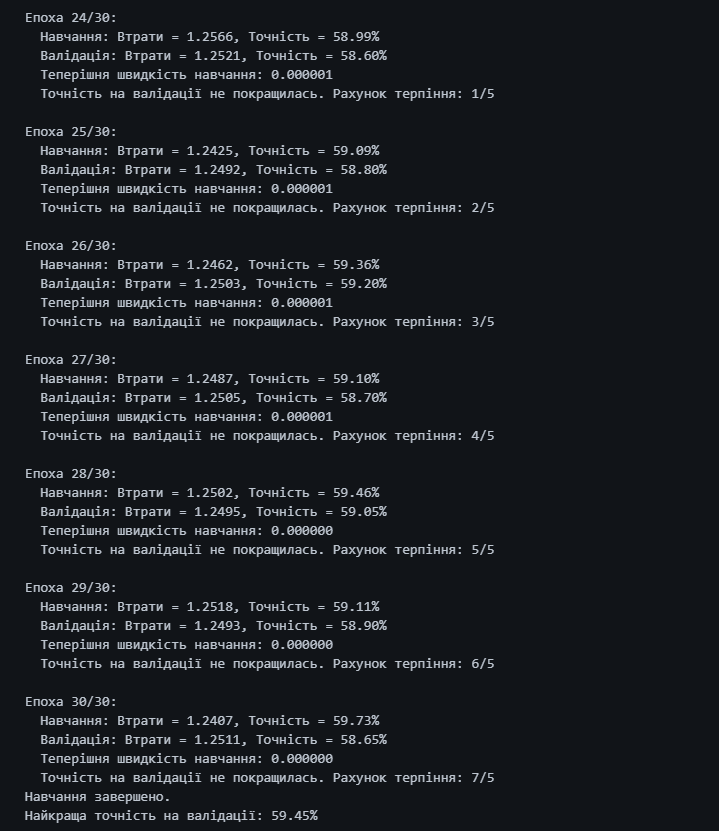